# Experiment for neural style transfer using Resnet (ConvLayers)

In [1]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

device = ("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive')
! cp -r 'drive/MyDrive/ds301HW/neural style transfer' '/content' 

In [72]:
content_path = "neural style transfer/images/1.jpeg"
style_path = "neural style transfer/style/1.jpeg"

layers = {'conv1':None,  'maxpool':None, 'layer2': None, 'layer4': None}

style_wt_meas = {'conv1' : 1.0, 
                 'maxpool' : 0.8,
                 'layer2' : 0.5,
                 'layer4' : 0.2}

content_wt = 10
style_wt = 1e5

model = models.resnet50(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

COntent shape =>  torch.Size([3, 300, 533])


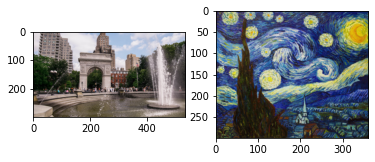

In [73]:

def model_activations(input,model): 
  global layers
  features = {}
  x = input
  x = x.unsqueeze(0)
  for name,layer in model._modules.items():
    if name != 'fc':
      x = layer(x)
      if name in layers.keys():
        features[name] = x 

  return features

def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    return gram_mat

def preprocess_and_plot(plot = True):
  global content_path, style_path
  transform = transforms.Compose([transforms.Resize(300),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

  content = Image.open(content_path).convert("RGB")
  content = transform(content).to(device)
  print("COntent shape => ", content.shape)
  style = Image.open(style_path).convert("RGB")
  style = transform(style).to(device)

  if plot:
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(imcnvt(content),label = "Content")
    ax2.imshow(imcnvt(style),label = "Style")
    plt.show()
  target = content.clone().requires_grad_(True).to(device)
  return content, style, target


# feature extracted by vgg's 6 conv layer
def extract_features(content, style):
  global model, layers
  style_features = model_activations(style,model)
  content_features = model_activations(content,model)
  style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}
  return content_features, style_features, style_grams

content, style, target = preprocess_and_plot(plot = True)

epoch  1000   tensor(1.4637e+12, device='cuda:0', grad_fn=<AddBackward0>)


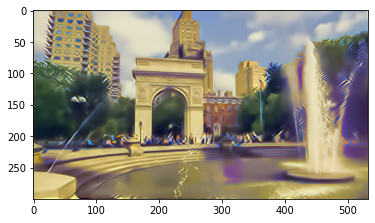

epoch  2000   tensor(8.1121e+11, device='cuda:0', grad_fn=<AddBackward0>)


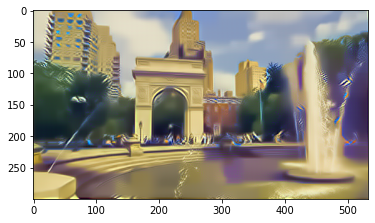

epoch  3000   tensor(5.6011e+11, device='cuda:0', grad_fn=<AddBackward0>)


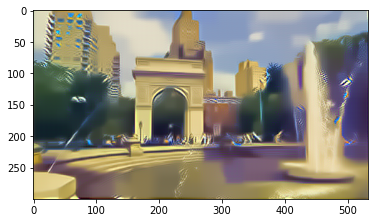

epoch  4000   tensor(4.1887e+11, device='cuda:0', grad_fn=<AddBackward0>)


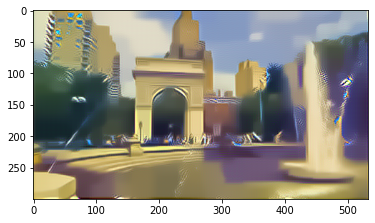

In [74]:
def training_loop(content_features, target, style_grams, epochs = 4000, print_after = 1000):
  optimizer = torch.optim.Adam([target],lr=0.007)
  for i in range(1,epochs+1):
      target_features = model_activations(target,model)
      content_loss = torch.mean((content_features['layer4']-target_features['layer4'])**2)

      style_loss = 0
      for layer in style_wt_meas:
          style_gram = style_grams[layer]
          target_gram = target_features[layer]
          _,d,w,h = target_gram.shape
          target_gram = gram_matrix(target_gram)
          style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
      
      total_loss = content_wt*content_loss + style_wt*style_loss 
      
      if i%1000==0:       
          print("epoch ",i," ", total_loss)
      
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      if i%print_after == 0:
          plt.imshow(imcnvt(target),label="Epoch "+str(i))
          plt.show()
          plt.imsave(str(i)+'.png',imcnvt(target),format='png')

#content, style, target = preprocess_and_plot()
content_features, style_features, style_grams = extract_features(content, style)
training_loop(content_features, target, style_grams)